In [11]:
import matplotlib, os, sys
import matplotlib.font_manager
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'Times'
rcParams['font.sans-serif'] = 'Helvetica'
rcParams['font.cursive'] = 'Zapf Chancery'
rcParams['font.monospace'] = 'Computer Modern Typewriter'

font_size = 7
rcParams['axes.labelsize'] = font_size
rcParams['axes.titlesize'] = font_size
rcParams['xtick.labelsize'] = font_size
rcParams['ytick.labelsize'] = font_size
rcParams['axes.titlesize'] = font_size
rcParams['font.size'] = font_size
rcParams['text.usetex'] = 'false'
rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

rcParams['axes.linewidth']= 0.5
rcParams['lines.linewidth']= 1.0

#import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from scipy.io import loadmat
from pathlib import Path
from scipy.interpolate import interp1d, RectBivariateSpline, interp2d, CloughTocher2DInterpolator, interpn
from scipy.integrate import cumtrapz
from scipy.optimize import minimize

sys.path.append('../../..')
sys.path.append('../..')
sys.path.append('../')

from tqdm import tqdm
from setup import *
from modules.Espec import *#get_raw_image
from lib.general_tools import imagesc, load_object, calc_COW, d, smooth_gauss
from lib.general_tools import choose_cal_file, glob_path, get_file_path, save_object
from lib.analysis_database import Database

#from RR2021.paths import ROOT_DATA_FOLDER, CALIB_FOLDER
#from RR2021 import PKG_DATA

DATA_PATH =Path(ROOT_DATA_FOLDER)
DATA_PATH

PosixPath('/data/instrument/GEMINI/2021/App20110008-1/MIRAGE')

In [12]:
analysis_path = Path(r'/data/analysis/GEMINI/2021/App20110008-1/Results/')
diag = 'GammaProfile'
database_file = analysis_path / f'{diag}_results_main.pkl'
gammaProf_db = Database(database_file,always_load=True)
gammaProf_db.dataframe.head()

img_med  img_max
run            shot                  
20210604/run02 1        99.0    111.0
               2        99.0    108.0
               3        98.0    111.0
               4        99.0    119.0
               5        99.0    120.0

In [13]:
s_sum = []
for n,row in gammaProf_db.dataframe.iterrows():
    run_name,shot = row.name
    spectra_path = Path('/data/analysis/GEMINI/2021/App20110008-1/Results/Espec/Spectra') / run_name.replace('/','_')
    espec_file = spectra_path / f'Shot{shot:04}_spectra.pkl'
    if os.path.isfile(espec_file):
        espec_data = load_object(espec_file)
        E_MeV,y_mrad,spec1 = espec_data['E_MeV'],espec_data['y1_mrad'],espec_data['spec1']
        s_sum.append(np.trapz(np.trapz(spec1,x=y_mrad,axis=0),x=E_MeV))
    else:
        s_sum.append(0.0)

Text(0, 0.5, 'Electron beam charge')

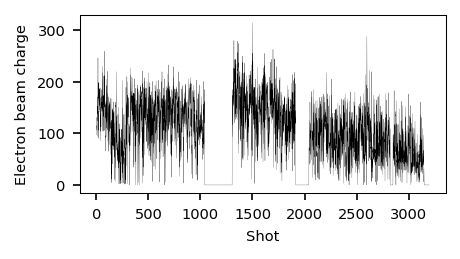

In [14]:
plt.figure(figsize=np.array([8,4])/2.54,dpi=150)
plt.plot(s_sum,'k-',lw=.1)
plt.xlabel('Shot')
plt.ylabel('Electron beam charge')

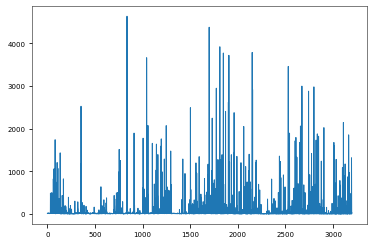

In [15]:
gamma_sig = gammaProf_db.dataframe['img_max'].values-gammaProf_db.dataframe['img_med'].values
plt.plot(gamma_sig)

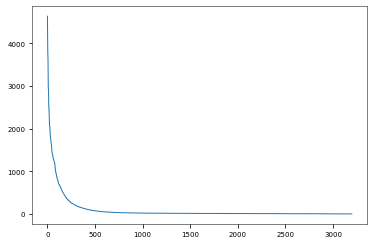

In [16]:
i_sort = np.argsort(gamma_sig)[::-1]
plt.plot(gamma_sig[i_sort])

In [17]:
g_thresh = 2000
g_max = 400000
gamma_sort = gamma_sig[i_sort]
g_sel = (gamma_sort>g_thresh)*(gamma_sort<g_max)
e_sel = np.array(s_sum)>50
N_sel = np.sum(g_sel)
i_sel = i_sort[g_sel]
i_sel = i_sel[e_sel[i_sel]]
N_sel = len(i_sel)
N_sel

21

In [18]:
g_zero = 100
n = np.arange(len(gamma_sig))[(gamma_sig<g_zero)*e_sel]
i_null=[]
for ind in i_sel:

    i_diff = np.abs(n-ind)
    i_null.append(n[np.argmin(i_diff)])

i_null

[837,
 1698,
 1810,
 2150,
 1847,
 1905,
 2531,
 2675,
 2798,
 1773,
 2154,
 2744,
 1902,
 2675,
 352,
 1501,
 1870,
 1730,
 3111,
 2659,
 2063]

In [19]:
from PIL import Image
from scipy.ndimage import median_filter

def load_img(file_path):
    return np.array(Image.open(file_path)).astype(float)
bkg_img = 0
def prep_img_file(file_path):
    img = load_img(file_path)-bkg_img
    img = median_filter(img,9)
    
    return img


In [20]:

for ind in i_sel:
    row = gammaProf_db.dataframe.iloc[ind]
    run_name,shot = row.name
    print(row.name)

('20210604/run23', 41)
('20210620/run10', 55)
('20210620/run10', 167)
('20210620/run11', 106)
('20210620/run10', 204)
('20210620/run10', 262)
('20210620/run14', 24)
('20210620/run15', 82)
('20210620/run15', 208)
('20210620/run10', 130)
('20210620/run11', 110)
('20210620/run15', 152)
('20210620/run10', 257)
('20210620/run15', 83)
('20210604/run09', 5)
('20210620/run08', 58)
('20210620/run10', 227)
('20210620/run10', 87)
('20210620/run17', 63)
('20210620/run15', 67)
('20210620/run11', 17)


In [21]:
g_img_list = []
for ind in i_sel:
    row = gammaProf_db.dataframe.iloc[ind]
    run_name,shot = row.name

    file_path = get_file_path(diag,run_name,None,shot)
    img = prep_img_file(file_path)
    cx,cy = calc_COW(img,img_thresh=np.percentile(img,99.9)/2)
    y_sel = np.arange(-200,200)+int(cy)
    x_sel = np.arange(-200,200)+int(cx)
    XS,YS = np.meshgrid(x_sel,y_sel)
    img = img[YS,XS]
    g_img_list.append(img)

g_null_list = []
for ind in i_null:
    row = gammaProf_db.dataframe.iloc[ind]
    run_name,shot = row.name

    file_path = get_file_path(diag,run_name,None,shot)
    img = prep_img_file(file_path)
    cx,cy = calc_COW(img,img_thresh=np.percentile(img,99.9)/2)
    y_sel = np.arange(-120,120)+int(cy)
    x_sel = np.arange(-120,120)+int(cx)
    XS,YS = np.meshgrid(x_sel,y_sel)
    img = img[YS,XS]
    g_null_list.append(img)

# electron data

In [22]:
e_img_list = []
for ind in i_sel:
    row = gammaProf_db.dataframe.iloc[ind]
    run_name,shot = row.name

    spectra_path = Path('/data/analysis/GEMINI/2021/App20110008-1/Results/Espec/Spectra') / run_name.replace('/','_')
    espec_file = spectra_path / f'Shot{shot:04}_spectra.pkl'
    if os.path.isfile(espec_file):
        espec_data = load_object(espec_file)
        E_MeV,y_mrad,spec1 = espec_data['E_MeV'],espec_data['y1_mrad'],espec_data['spec1']
        y0 = y_mrad[np.argmax(np.sum(spec1,axis=1))]
        y_mrad_disp = np.linspace(-4.5,4.5,100)
        spec_img = RectBivariateSpline(y_mrad-y0,E_MeV,spec1)(y_mrad_disp,E_MeV)
        e_img_list.append(spec_img)
    else:
        e_img_list.append(spec_img*np.nan)

e_null_list = []
for ind in i_null:
    row = gammaProf_db.dataframe.iloc[ind]
    run_name,shot = row.name

    spectra_path = Path('/data/analysis/GEMINI/2021/App20110008-1/Results/Espec/Spectra') / run_name.replace('/','_')
    espec_file = spectra_path / f'Shot{shot:04}_spectra.pkl'
    if os.path.isfile(espec_file):
        espec_data = load_object(espec_file)
        E_MeV,y_mrad,spec1 = espec_data['E_MeV'],espec_data['y1_mrad'],espec_data['spec1']
        y0 = y_mrad[np.argmax(np.sum(spec1,axis=1))]
        y_mrad_disp = np.linspace(-4.5,4.5,100)
        spec_img = RectBivariateSpline(y_mrad-y0,E_MeV,spec1)(y_mrad_disp,E_MeV)
        e_null_list.append(spec_img)
    else:
        e_null_list.append(spec_img*np.nan)

# Plot results

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


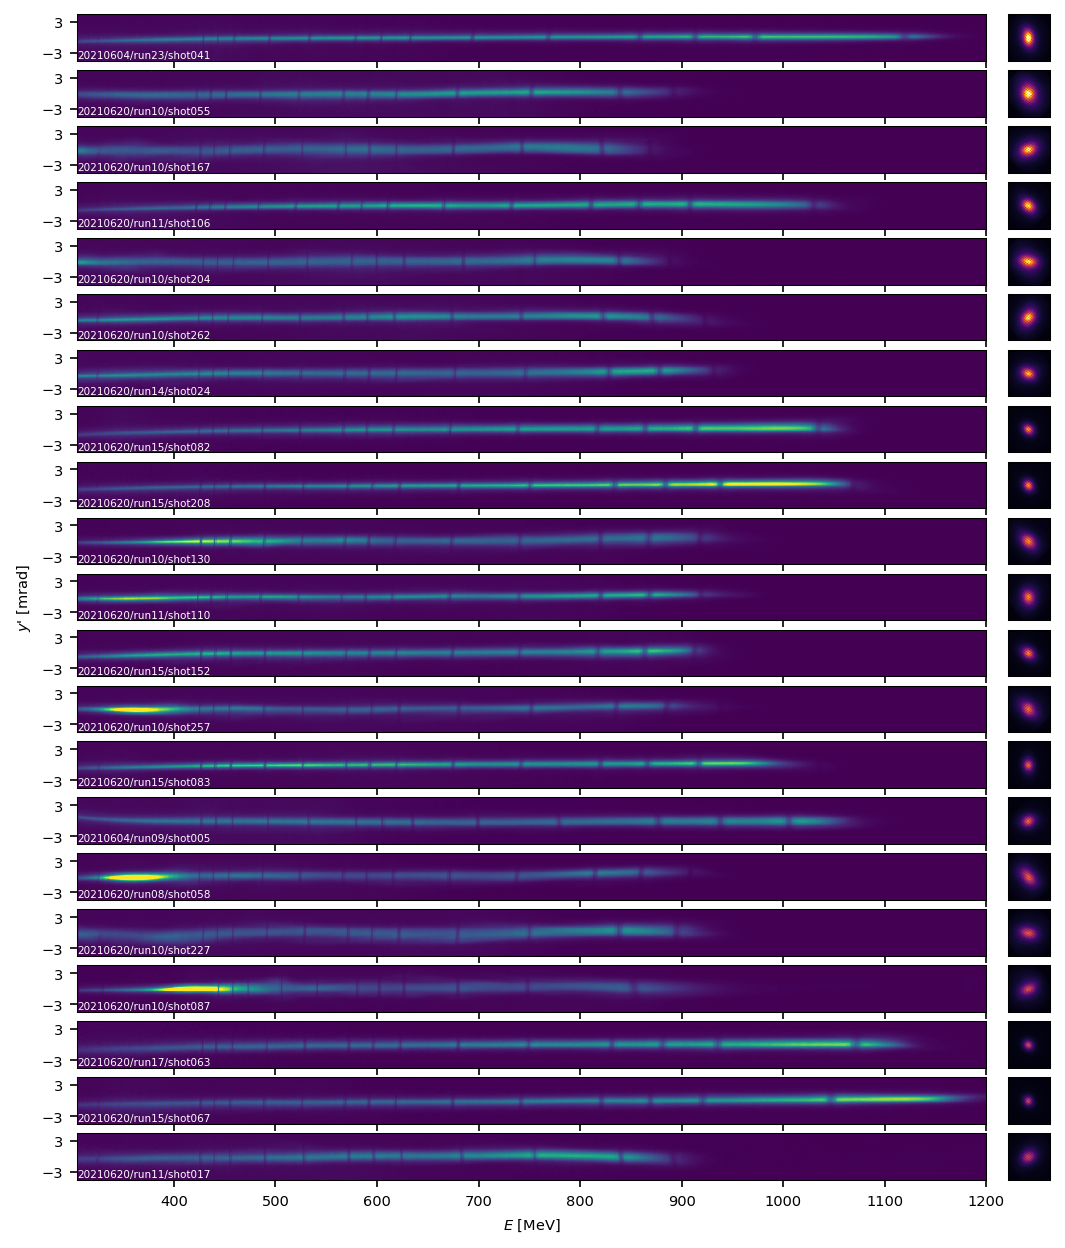

In [23]:
N = len(i_sel)
figsize_in = np.array([18,1*N])/2.54
fig,axs = plt.subplots(N_sel,1,figsize=figsize_in,dpi=150)
plt.subplots_adjust(left=0.065,right=0.92,top=0.99,bottom=0.05)
axs = axs.flatten()
axs_g = []
for ax in axs:
    ax_pos = ax.get_position()
    ax_pos2 = [ax_pos.x0+ax_pos.width+0.02, ax_pos.y0,0.04,ax_pos.height]
    axs_g.append(fig.add_axes(ax_pos2))
    
for ax,img in zip(axs_g,g_img_list):
    ax.pcolormesh(img,vmin=0,vmax=4000,cmap='inferno')
    ax.set_xticks([])
    ax.set_yticks([])

for n,(ax,img) in enumerate(zip(axs,e_img_list)):
    
    
    row = gammaProf_db.dataframe.iloc[i_sel[n]]
    run_name,shot = row.name
    if np.any(np.isnan(img)):
        ax.text(np.min(E_MeV),-4,f'{run_name}/shot{shot:03}',color='r',fontsize=5)
    else:
        ax.pcolormesh(E_MeV,y_mrad_disp,img/np.mean(img)*E_MeV/1e3,shading='auto',vmin=0,vmax=15)
        ax.text(np.min(E_MeV),-4,f'{run_name}/shot{shot:03}',color='w',fontsize=5)
        
    ax.set_xlim([np.min(E_MeV),1200])
    ax.set_ylim([np.min(y_mrad_disp),np.max(y_mrad_disp)])
    ax.set_yticks([-3,3])
    
ax.set_xlabel(r'$E$ [MeV]')
for ax in axs[:-1]:
    ax.set_xticklabels([])
    
axs[int(N/2)].set_ylabel(r"$y$' [mrad]")

plt.savefig('Best_hits.png',dpi=600)
# fig.add_axes([0,0,1,1],fc='none')

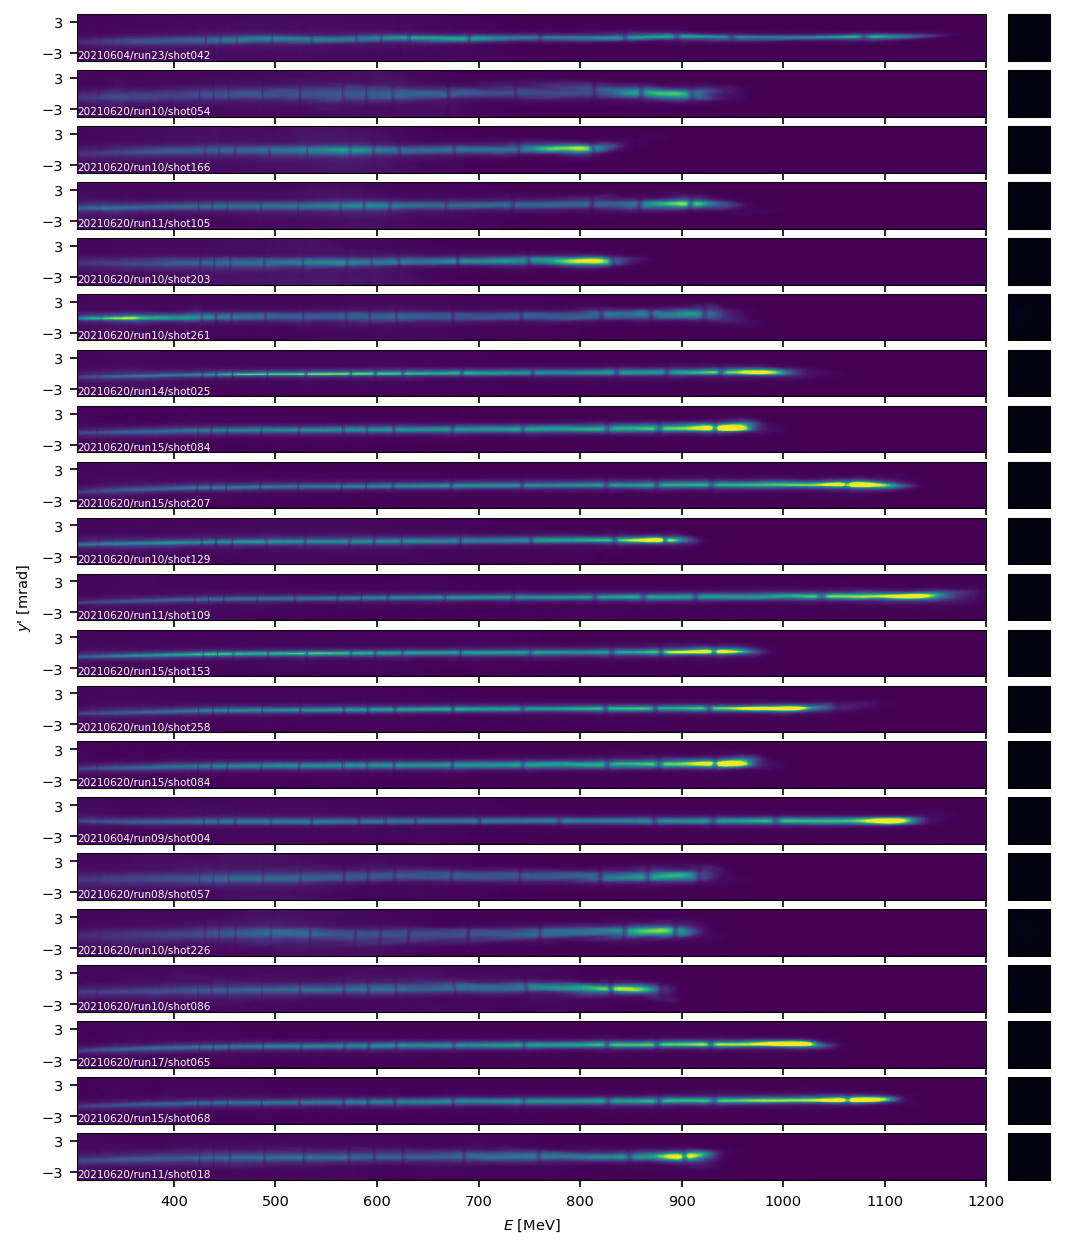

In [24]:
figsize_in = np.array([18,1*N_sel])/2.54
fig,axs = plt.subplots(N_sel,1,figsize=figsize_in,dpi=150)
plt.subplots_adjust(left=0.065,right=0.92,top=0.99,bottom=0.05)
axs = axs.flatten()
axs_g = []
for ax in axs:
    ax_pos = ax.get_position()
    ax_pos2 = [ax_pos.x0+ax_pos.width+0.02, ax_pos.y0,0.04,ax_pos.height]
    axs_g.append(fig.add_axes(ax_pos2))
    
for ax,img in zip(axs_g,g_null_list):
    ax.pcolormesh(img,vmin=0,vmax=4000,cmap='inferno')
    ax.set_xticks([])
    ax.set_yticks([])

for n,(ax,img) in enumerate(zip(axs,e_null_list)):
    
    row = gammaProf_db.dataframe.iloc[i_null[n]]
    run_name,shot = row.name
    if np.any(np.isnan(img)):
        ax.text(np.min(E_MeV),-4,f'{run_name}/shot{shot:03}',color='r',fontsize=5)
    else:
        ax.pcolormesh(E_MeV,y_mrad_disp,img/np.mean(img)*E_MeV/1e3,shading='auto',vmin=0,vmax=15)
        ax.text(np.min(E_MeV),-4,f'{run_name}/shot{shot:03}',color='w',fontsize=5)
    ax.set_xlim([np.min(E_MeV),1200])
    ax.set_ylim([np.min(y_mrad_disp),np.max(y_mrad_disp)])
    ax.set_yticks([-3,3])
        
ax.set_xlabel(r'$E$ [MeV]')
for n,ax in enumerate(axs[:-1]):
    ax.set_xticklabels([])
for n,ax in enumerate(axs):
    row = gammaProf_db.dataframe.iloc[i_null[n]]
    run_name,shot = row.name

    
axs[int(N/2)].set_ylabel(r"$y$' [mrad]")

plt.savefig('Adjacent_nulls.png',dpi=600)

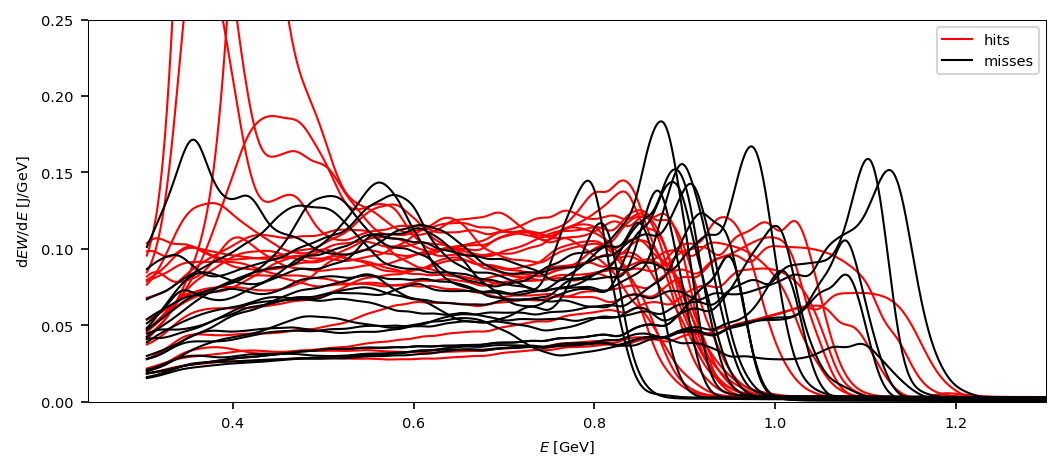

In [25]:
figsize_in = np.array([18,8])/2.54
fig,axs = plt.subplots(1,1,figsize=figsize_in,dpi=150)
N_plot = 20
W = []
for n,img in enumerate(e_img_list[:N_plot]):
    dWdE = smooth_gauss(E_MeV,1e-3*E_MeV*np.trapz(img,x=y_mrad_disp,axis=0),10)
    W.append(dWdE)
    
    if n==0:
        plt.plot(E_MeV/1e3,dWdE,'r-',label='hits')
    else:
        plt.plot(E_MeV/1e3,dWdE,'r-')
        
    
W_null=[]
for n,img in enumerate(e_null_list[:N_plot]):
    dWdE = smooth_gauss(E_MeV,1e-3*E_MeV*np.trapz(img,x=y_mrad_disp,axis=0),10)
    W_null.append(dWdE)
    if n==0:
        plt.plot(E_MeV/1e3,dWdE,'k-',label='misses')
    else:
        plt.plot(E_MeV/1e3,dWdE,'k-')
# plt.plot(E_MeV/1e3,np.nanmean(W_null,axis=0),'k-')
# plt.plot(E_MeV/1e3,np.nanmean(W,axis=0),'r-')
plt.xlim([None,1.300])
plt.ylim([0,0.25])
plt.xlabel(r'$E$ [GeV]')
plt.ylabel(r'd$EW/$d$E$ [J/GeV]')
plt.tight_layout()
plt.legend()
plt.savefig('Hits_vs_misses_mid.png',dpi=600)

In [26]:
W_tot = np.trapz(W,x=E_MeV/1e3,axis=1)
W_null_tot = np.trapz(W_null,x=E_MeV/1e3,axis=1)

In [27]:
np.nanmean(W_tot)

0.06159537117831191

In [28]:
np.nanstd(W_tot)/np.sqrt(np.sum(np.isfinite(W_tot)))

0.003720922404357915

In [29]:
np.nanmean(W_null_tot)

0.0477174415513365

In [30]:
np.nanstd(W_null_tot)/np.sqrt(np.sum(np.isfinite(W_null_tot)))

0.003179419199918849

In [31]:
C_tot = np.trapz(W/E_MeV,x=E_MeV/1e3,axis=1)
C_null_tot = np.trapz(W_null/E_MeV,x=E_MeV/1e3,axis=1)

In [32]:
np.nanmean(C_tot*1e3)

0.10637175357488464

In [33]:
np.nanmean(C_null_tot*1e3)

0.07788911811340608

In [34]:
np.nanstd(C_tot*1e3)

0.036934411043357436

In [35]:
np.nanstd(C_null_tot*1e3)

0.026414601240147002

In [36]:
W_avg = np.trapz(W,x=E_MeV,axis=1)/np.trapz(W/E_MeV,x=E_MeV,axis=1)
W_null_avg = np.trapz(W_null,x=E_MeV,axis=1)/np.trapz(W_null/E_MeV,x=E_MeV,axis=1)


In [37]:
np.nanmean(W_avg)

596.5238165810703

In [38]:
np.nanstd(W_avg)/np.sqrt(np.sum(np.isfinite(W_avg)))

13.462416459912244

In [39]:
np.nanmean(W_null_avg)

623.4648049050221

In [40]:
np.nanstd(W_null_avg)/np.sqrt(np.sum(np.isfinite(W_null_avg)))

11.727046189979003